In [1]:
# Importing all the required packages

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime, nltk, warnings
import matplotlib.cm as cm
import itertools
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing, model_selection, metrics, feature_selection
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn import neighbors, linear_model, svm, tree, ensemble
from wordcloud import WordCloud, STOPWORDS
from sklearn.ensemble import AdaBoostClassifier
from sklearn.decomposition import PCA
from IPython.display import display, HTML

C:\Users\me\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
# Data Preparation

# read the datafile
df_initial = pd.read_csv('C:/Users/me/Desktop/data.csv',encoding="ISO-8859-1",dtype={'CustomerID':str,'InvoiceID':str})
                        
print('Dataframe dimensions:', df_initial.shape)
df_initial['InvoiceDate'] = pd.to_datetime(df_initial['InvoiceDate'])


Dataframe dimensions: (541909, 8)


In [3]:
# show first lines
display(df_initial[:5])

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


In [4]:
# Exploratory Data Analysis
# Identify null values

# Gives some infomation on columns types and number of null values
tab_info=pd.DataFrame(df_initial.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()/df_initial.shape[0]*100).T.
                         rename(index={0:'null values (%)'}))
print ('-' * 10 + " Display information about column types and number of null values " + '-' * 10 )
print 
display(tab_info)

---------- Display information about column types and number of null values ----------


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
column type,object,object,object,int64,datetime64[ns],float64,object,object
null values (nb),0,0,1454,0,0,0,135080,0
null values (%),0,0,0.268311,0,0,0,24.9267,0


In [5]:
# Remove data entries

#Note:

#If you are looking to the CustomerID column then there are \sim25% data entries are null.

df_initial.dropna(axis = 0, subset = ['CustomerID'], inplace = True)
print('Dataframe dimensions:', df_initial.shape)
# gives some information on columns types and number of null values
tab_info=pd.DataFrame(df_initial.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()/df_initial.shape[0]*100).T.
                         rename(index={0:'null values (%)'}))
display(tab_info)

Dataframe dimensions: (406829, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
column type,object,object,object,int64,datetime64[ns],float64,object,object
null values (nb),0,0,0,0,0,0,0,0
null values (%),0,0,0,0,0,0,0,0


In [6]:
print('Duplicate data entries: {}'.format(df_initial.duplicated().sum()))
df_initial.drop_duplicates(inplace = True)

Duplicate data entries: 5225


In [7]:
# Exploring data attributes
# Exploring the data attribute : Country

temp = df_initial[['CustomerID', 'InvoiceNo', 'Country']].groupby(
    ['CustomerID', 'InvoiceNo', 'Country']).count()
temp = temp.reset_index(drop = False)
countries = temp['Country'].value_counts()
print('No. of cuntries in dataframe: {}'.format(len(countries)))

No. of cuntries in dataframe: 37


In [8]:
temp_no_of_order_per_count = df_initial[['CustomerID','Country']].groupby(['Country']).count()
temp_no_of_order_per_count = temp_no_of_order_per_count.reset_index(drop = False)

print('-' * 10 + " Contry-wise order calculation "+ '-' * 10)
print
print (temp_no_of_order_per_count.sort_values(
    by='CustomerID', ascending=False).rename(index=str,
                                        columns={"CustomerID": "Country wise number of order"}))

---------- Contry-wise order calculation ----------
                 Country  Country wise number of order
35        United Kingdom                        356728
14               Germany                          9480
13                France                          8475
10                  EIRE                          7475
30                 Spain                          2528
23           Netherlands                          2371
3                Belgium                          2069
32           Switzerland                          1877
26              Portugal                          1471
0              Australia                          1258
24                Norway                          1086
18                 Italy                           803
6        Channel Islands                           757
12               Finland                           695
7                 Cyprus                           611
31                Sweden                           461
1            

In [9]:
# Exploring the data attribute : Customers and products 
#The dataframe contains $\sim$400,000 entries. What are the number of users and products in these entries ?

pd.DataFrame([{'products': len(df_initial['StockCode'].value_counts()),    
               'transactions': len(df_initial['InvoiceNo'].value_counts()),
               'customers': len(df_initial['CustomerID'].value_counts()),  
              }], columns = ['products', 'transactions', 'customers'], 
              index = ['quantity'])

,products,transactions,customers
quantity,3684,22190,4372


In [10]:
# As you can see that this dataset contain the recods of 4372 users who bought 3684 different items. There are $\sim$22,000 transactions which are carried out.

# Now we need to explore the number of products purchased in every transaction

temp = df_initial.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
nb_products_per_basket = temp.rename(columns = {'InvoiceDate':'Number of products'})
nb_products_per_basket[:10].sort_values('CustomerID')




,CustomerID,InvoiceNo,Number of products
0,12346,541431,1
1,12346,C541433,1
2,12347,537626,31
3,12347,542237,29
4,12347,549222,24
5,12347,556201,18
6,12347,562032,22
7,12347,573511,47
8,12347,581180,11
9,12348,539318,17


In [11]:
## Observation -

# There are some users who bought only one time on the E-commerce platform and purchased one item.

# The example of this kind of user is customerID 12346.

# There are some users who frequently buy large number of items per order. The example of this kind of user is customerID 12347.




In [12]:
# Analysis of cancelled orders 

nb_products_per_basket['order_cancelled'] = nb_products_per_basket['InvoiceNo'].apply(
    lambda x:int('C' in x))
display(nb_products_per_basket[:5])


n1 = nb_products_per_basket['order_cancelled'].sum()
n2 = nb_products_per_basket.shape[0]
percentage = (n1/n2)*100
print('Number of orders cancelled: {}/{} ({:.2f}%) '.format(n1, n2, percentage))

,CustomerID,InvoiceNo,Number of products,order_cancelled
0,12346,541431,1,0
1,12346,C541433,1,1
2,12347,537626,31,0
3,12347,542237,29,0
4,12347,549222,24,0


Number of orders cancelled: 3654/22190 (16.47%) 


In [13]:
# Number of orders cancelled: 3654/22190 (16.47%) 
# Note that the number of cancelled transactions are quite large ( $\sim$16% of the total number of transactions).
# Now, let's look at the first few lines of the dataframe

display(df_initial.sort_values('CustomerID')[:5])

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346,United Kingdom
286623,562032,22375,AIRLINE BAG VINTAGE JET SET BROWN,4,2011-08-02 08:48:00,4.25,12347,Iceland
72260,542237,84991,60 TEATIME FAIRY CAKE CASES,24,2011-01-26 14:30:00,0.55,12347,Iceland
14943,537626,22772,PINK DRAWER KNOB ACRYLIC EDWARDIAN,12,2010-12-07 14:57:00,1.25,12347,Iceland


In [14]:
# From the above output, we see that when an order is canceled, we have another transactions in the dataframe. 
# I decide to check if this is true for all the entries.


df_check = df_initial[df_initial['Quantity'] < 0][['CustomerID','Quantity',
                                                   'StockCode','Description','UnitPrice']]
for index, col in  df_check.iterrows():
    if df_initial[(df_initial['CustomerID'] == col[0]) & (df_initial['Quantity'] == -col[1]) 
                & (df_initial['Description'] == col[2])].shape[0] == 0: 
        print(df_check.loc[index])
        print(15*'-'+'>'+' HYPOTHESIS NOT FULFILLED')
        break

CustomerID        14527
Quantity             -1
StockCode             D
Description    Discount
UnitPrice          27.5
Name: 141, dtype: object
---------------> HYPOTHESIS NOT FULFILLED


In [15]:
# We see that the initial hypothesis is not fulfilled because of the existence of a 'Discount' entry.
# I check again the hypothesis but this time discarding the 'Discount' entries:

df_check = df_initial[(df_initial['Quantity'] < 0) & (df_initial['Description'] != 'Discount')][
                                 ['CustomerID','Quantity','StockCode',
                                  'Description','UnitPrice']]

for index, col in  df_check.iterrows():
    if df_initial[(df_initial['CustomerID'] == col[0]) & (df_initial['Quantity'] == -col[1]) 
                & (df_initial['Description'] == col[2])].shape[0] == 0: 
        print(index, df_check.loc[index])
        print(15*'-'+'>'+' HYPOTHESIS NOT FULFILLED')
        break

154 CustomerID                               15311
Quantity                                    -1
StockCode                               35004C
Description    SET OF 3 COLOURED  FLYING DUCKS
UnitPrice                                 4.65
Name: 154, dtype: object
---------------> HYPOTHESIS NOT FULFILLED


In [16]:
# Once more, We find that the initial hypothesis is not verified. Hence, cancellations do not necessarily correspond to orders that would have been made beforehand.

# At this point, I decide to create a new variable in the dataframe that indicate if part of the command has been canceled. 
# For the cancellations without counterparts, a few of them are probably due to the fact that the buy orders were performed before December 2010 (the point of entry of the database).
# Below, I make a census of the cancel orders and check for the existence of counterparts:


df_cleaned = df_initial.copy(deep = True)
df_cleaned['QuantityCanceled'] = 0

entry_to_remove = [] ; doubtfull_entry = []

for index, col in  df_initial.iterrows():
    if (col['Quantity'] > 0) or col['Description'] == 'Discount': continue        
    df_test = df_initial[(df_initial['CustomerID'] == col['CustomerID']) &
                         (df_initial['StockCode']  == col['StockCode']) & 
                         (df_initial['InvoiceDate'] < col['InvoiceDate']) & 
                         (df_initial['Quantity']   > 0)].copy()

    # Cancelation WITHOUT counterpart
    if (df_test.shape[0] == 0): 
        doubtfull_entry.append(index)
   
    # Cancelation WITH a counterpart
    elif (df_test.shape[0] == 1): 
        index_order = df_test.index[0]
        df_cleaned.loc[index_order, 'QuantityCanceled'] = -col['Quantity']
        entry_to_remove.append(index)        
   
    # Various counterparts exist in orders: we delete the last one
    elif (df_test.shape[0] > 1): 
        df_test.sort_index(axis=0 ,ascending=False, inplace = True)        
        for ind, val in df_test.iterrows():
            if val['Quantity'] < -col['Quantity']: continue
            df_cleaned.loc[ind, 'QuantityCanceled'] = -col['Quantity']
            entry_to_remove.append(index) 
            break

In [17]:
#In the above function, I checked the two cases:

# a cancel order exists without counterpart
# there's at least one counterpart with the exact same quantity
# The index of the corresponding cancel order are respectively kept in the doubtfull_entry and entry_to_remove lists whose sizes are:

In [18]:
print("entry_to_remove: {}".format(len(entry_to_remove)))
print("doubtfull_entry: {}".format(len(doubtfull_entry)))

entry_to_remove: 7521
doubtfull_entry: 1226


In [19]:
# Among these entries, the lines listed in the doubtfull_entry list correspond to the entries indicating a cancellation but for which there is no command beforehand. In practice, I decide to delete all of these entries, which count respectively for $\sim$ 1.4% and 0.2% of the dataframe entries.

#Now I check the number of entries that correspond to cancellations and that have not been deleted with the previous filter:

df_cleaned.drop(entry_to_remove, axis = 0, inplace = True)
df_cleaned.drop(doubtfull_entry, axis = 0, inplace = True)
remaining_entries = df_cleaned[(df_cleaned['Quantity'] < 0) & (df_cleaned['StockCode'] != 'D')]
print("nb of entries to delete: {}".format(remaining_entries.shape[0]))
remaining_entries[:5]

nb of entries to delete: 48


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled
77598,C542742,84535B,FAIRY CAKES NOTEBOOK A6 SIZE,-94,2011-01-31 16:26:00,0.65,15358,United Kingdom,0
90444,C544038,22784,LANTERN CREAM GAZEBO,-4,2011-02-15 11:32:00,4.95,14659,United Kingdom,0
111968,C545852,22464,HANGING METAL HEART LANTERN,-5,2011-03-07 13:49:00,1.65,14048,United Kingdom,0
116064,C546191,47566B,TEA TIME PARTY BUNTING,-35,2011-03-10 10:57:00,0.70,16422,United Kingdom,0
132642,C547675,22263,FELT EGG COSY LADYBIRD,-49,2011-03-24 14:07:00,0.66,17754,United Kingdom,0


In [20]:
# If one looks, for example, at the purchases of the consumer of one of the above entries and corresponding to the same product as that of the cancellation, one observes:
df_cleaned[(df_cleaned['CustomerID'] == 14048) & (df_cleaned['StockCode'] == '22464')]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled


In [21]:
# We see that the quantity canceled is greater than the sum of the previous purchases.



In [22]:
# Analysis of the StockCode
# Above, it has been seen that some values of the StockCode variable indicate a particular transaction (i.e. D for Discount).
# I check the contents of this variable by looking for the set of codes that would contain only letters:
list_special_codes = df_cleaned[df_cleaned['StockCode'].str.contains('^[a-zA-Z]+', regex=True)]['StockCode'].unique()
list_special_codes

array(['POST', 'D', 'C2', 'M', 'BANK CHARGES', 'PADS', 'DOT'],
      dtype=object)

In [23]:
for code in list_special_codes:
    print("{:<15} -> {:<30}".format(code, df_cleaned[df_cleaned['StockCode'] == code]['Description'].unique()[0]))

POST            -> POSTAGE                       
D               -> Discount                      
C2              -> CARRIAGE                      
M               -> Manual                        
BANK CHARGES    -> Bank Charges                  
PADS            -> PADS TO MATCH ALL CUSHIONS    
DOT             -> DOTCOM POSTAGE                


In [24]:
# We see that there are several types of peculiar transactions, connected e.g. to port charges or bank charges


In [25]:
# Analysis of Basket Price
# We create a new variable that indicates the total price of every purchase:

df_cleaned['TotalPrice'] = df_cleaned['UnitPrice'] * (df_cleaned['Quantity'] - df_cleaned['QuantityCanceled'])
df_cleaned.sort_values('CustomerID')[:5]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,TotalPrice
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom,74215,0.0
148288,549222,22375,AIRLINE BAG VINTAGE JET SET BROWN,4,2011-04-07 10:43:00,4.25,12347,Iceland,0,17.0
428971,573511,22698,PINK REGENCY TEACUP AND SAUCER,12,2011-10-31 12:25:00,2.95,12347,Iceland,0,35.4
428970,573511,47559B,TEA TIME OVEN GLOVE,10,2011-10-31 12:25:00,1.25,12347,Iceland,0,12.5
428969,573511,47567B,TEA TIME KITCHEN APRON,6,2011-10-31 12:25:00,5.95,12347,Iceland,0,35.7


In [26]:
# Each entry of the dataframe indicates prizes for a single kind of product. Hence, orders are split on several lines.
# We collect all the purchases made during a single order to recover the total order prize:


In [27]:
 # sum of purchases / user & order
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['TotalPrice'].sum()
basket_price = temp.rename(columns = {'TotalPrice':'Basket Price'})

# date of the order
df_cleaned['InvoiceDate_int'] = df_cleaned['InvoiceDate'].astype('int64')
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate_int'].mean()
df_cleaned.drop('InvoiceDate_int', axis = 1, inplace = True)
basket_price.loc[:, 'InvoiceDate'] = pd.to_datetime(temp['InvoiceDate_int'])

# selection of significant entries
basket_price = basket_price[basket_price['Basket Price'] > 0]
basket_price.sort_values('CustomerID')[:6]

,CustomerID,InvoiceNo,Basket Price,InvoiceDate
1,12347,537626,711.79,2010-12-07 14:57:00.000001024
2,12347,542237,475.39,2011-01-26 14:29:59.999999744
3,12347,549222,636.25,2011-04-07 10:42:59.999999232
4,12347,556201,382.52,2011-06-09 13:01:00.000000256
5,12347,562032,584.91,2011-08-02 08:48:00.000000000
6,12347,573511,1294.32,2011-10-31 12:25:00.000001280


In [28]:
# In order to have a global view of the type of order performed in this dataset
# We determine how the purchases are divided according to total prizes:

# Purchase count
price_range = [0, 50, 100, 200, 500, 1000, 5000, 50000]
count_price = []
for i, price in enumerate(price_range):
    if i == 0: continue
    val = basket_price[(basket_price['Basket Price'] < price) &
                       (basket_price['Basket Price'] > price_range[i-1])]['Basket Price'].count()
    count_price.append(val)

# Representation of the number of purchases / amount       
plt.rc('font', weight='bold')
f, ax = plt.subplots(figsize=(11, 6))
colors = ['yellowgreen', 'gold', 'wheat', 'c', 'violet', 'royalblue','firebrick']
labels = [ '{}<.<{}'.format(price_range[i-1], s) for i,s in enumerate(price_range) if i != 0]
sizes  = count_price
explode = [0.0 if sizes[i] < 100 else 0.0 for i in range(len(sizes))]
ax.pie(sizes, explode = explode, labels=labels, colors = colors,
       autopct = lambda x:'{:1.0f}%'.format(x) if x > 1 else '',
       shadow = False, startangle=0)
ax.axis('equal')
f.text(0.5, 1.01, "Distribution of order amounts", ha='center', fontsize = 18);

In [29]:
# It can be seen that the vast majority of orders concern relatively large purchases given that 65% of purchases give prizes in excess of £ 200.

In [30]:
# Analysis of the product categories
# In the data-frame, products are uniquely identified through the StockCode variable.
# A short description of the products is given in the Description variable. 
#In this section, We intend to use the content of this latter variable in order to group the products into different categories.


# Products Description
# As a first step, We extract from the Description variable the information that will prove useful.
# To do this, We use the following function:

is_noun = lambda pos: pos[:2] == 'NN'

def keywords_inventory(dataframe, colonne = 'Description'):
    stemmer = nltk.stem.SnowballStemmer("english")
    keywords_roots  = dict()  # collect the words / root
    keywords_select = dict()  # association: root <-> keyword
    category_keys   = []
    count_keywords  = dict()
    icount = 0
    for s in dataframe[colonne]:
        if pd.isnull(s): continue
        lines = s.lower()
        tokenized = nltk.word_tokenize(lines)
        nouns = [word for (word, pos) in nltk.pos_tag(tokenized) if is_noun(pos)] 
        
        for t in nouns:
            t = t.lower() ; racine = stemmer.stem(t)
            if racine in keywords_roots:                
                keywords_roots[racine].add(t)
                count_keywords[racine] += 1                
            else:
                keywords_roots[racine] = {t}
                count_keywords[racine] = 1
    
    for s in keywords_roots.keys():
        if len(keywords_roots[s]) > 1:  
            min_length = 1000
            for k in keywords_roots[s]:
                if len(k) < min_length:
                    clef = k ; min_length = len(k)            
            category_keys.append(clef)
            keywords_select[s] = clef
        else:
            category_keys.append(list(keywords_roots[s])[0])
            keywords_select[s] = list(keywords_roots[s])[0]
                   
    print("number of keywords in variable '{}': {}".format(colonne,len(category_keys)))
    return category_keys, keywords_roots, keywords_select, count_keywords

In [31]:
# Observation
# This function takes as input the dataframe and analyzes the content of the Description column by performing the following operations:

## extract the names (proper, common) appearing in the products description
## for each name, We extract the root of the word and aggregate the set of names associated with this particular root
## count the number of times each root appears in the dataframe
## when several words are listed for the same root, We consider that the keyword associated with this root is the shortest name (this systematically selects the singular when there are singular/plural variants)

In [32]:
# The first step of the analysis is to retrieve the list of products:

df_produits = pd.DataFrame(df_initial['Description'].unique()).rename(columns = {0:'Description'})

In [33]:
# Once this list is created, I use the function I previously defined in order to analyze the description of the various products:
keywords, keywords_roots, keywords_select, count_keywords = keywords_inventory(df_produits)

number of keywords in variable 'Description': 1483


In [34]:
# The execution of this function returns three variables:

# keywords: the list of extracted keywords
# keywords_roots: a dictionary where the keys are the keywords roots and the values are the lists of words associated with those roots
# count_keywords: dictionary listing the number of times every word is used

In [35]:
# At this point, We convert the count_keywords dictionary into a list, to sort the keywords according to their occurrence:

list_products = []
for k,v in count_keywords.items():
    list_products.append([keywords_select[k],v])
list_products.sort(key = lambda x:x[1], reverse = True)

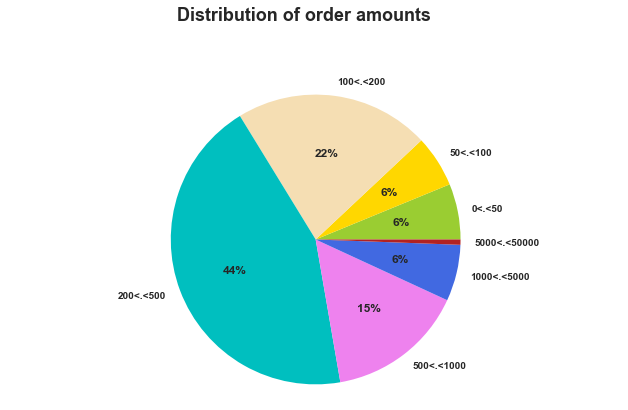

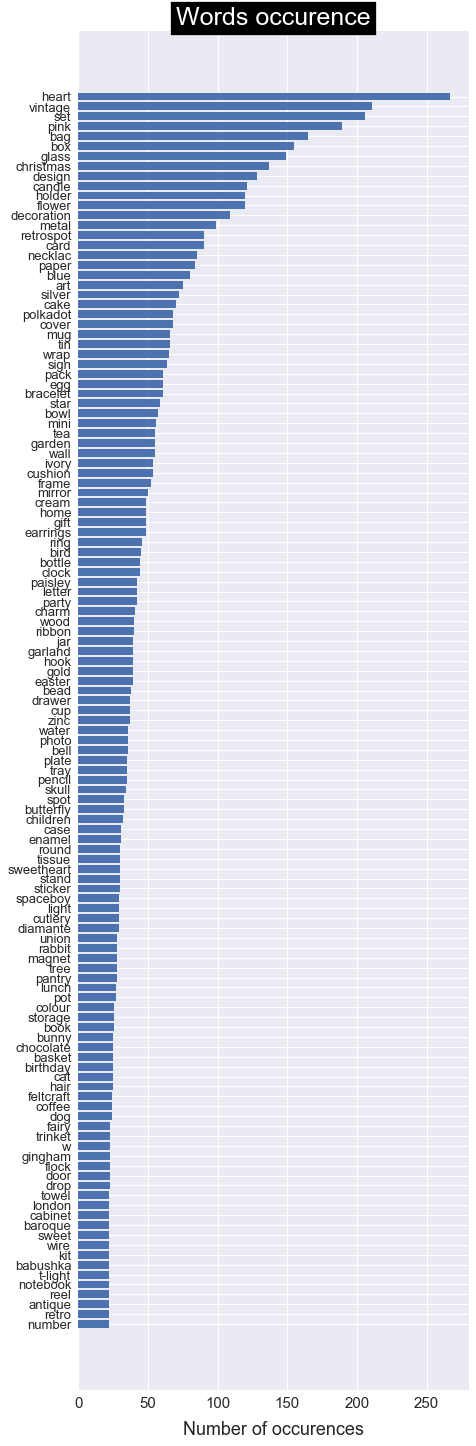

In [36]:
# Using it, We create a representation of the most common keywords:

liste = sorted(list_products, key = lambda x:x[1], reverse = True)

plt.rc('font', weight='normal')
fig, ax = plt.subplots(figsize=(7, 25))
y_axis = [i[1] for i in liste[:125]]
x_axis = [k for k,i in enumerate(liste[:125])]
x_label = [i[0] for i in liste[:125]]
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 13)
plt.yticks(x_axis, x_label)
plt.xlabel("Number of occurences", fontsize = 18, labelpad = 10)
ax.barh(x_axis, y_axis, align = 'center')
ax = plt.gca()
ax.invert_yaxis()

plt.title("Words occurence",bbox={'facecolor':'k', 'pad':5}, color='w',fontsize = 25)
plt.show()



In [37]:
# Defining product categories
# The list that was obtained contains more than 1400 keywords and the most frequent ones appear in more than 200 products. 
# However, while examining the content of the list, I note that some names are useless. 
# Others are do not carry information, like colors. Therefore, I discard these words from the analysis that follows and also
# I decide to consider only the words that appear more than 13 times.

list_products = []
for k,v in count_keywords.items():
    word = keywords_select[k]
    if word in ['pink', 'blue', 'tag', 'green', 'orange']: continue
    if len(word) < 3 or v < 13: continue
    if ('+' in word) or ('/' in word): continue
    list_products.append([word, v])
 
list_products.sort(key = lambda x:x[1], reverse = True)
print('Preserved words:', len(list_products))

Preserved words: 193


In [38]:
# Data encoding
# Now We will use these keywords to create groups of product. Firstly, We define the X matrix as:
# where the a_ {i, j} coefficient is 1 if the description of the product i contains the word j, and 0 otherwise.

liste_produits = df_cleaned['Description'].unique()
#print(liste_produits[0:2])
X = pd.DataFrame()
for key, occurence in list_products:
    X.loc[:, key] = list(map(lambda x:int(key.upper() in x), liste_produits))
# print(X[0:1])    
# The X matrix indicates the words contained in the description of the products using the one-hot-encoding principle.
# In practice, We have found that introducing the price range results in more balanced groups in terms of element numbers.
# Hence, I add 6 extra columns to this matrix, where I indicate the price range of the products:




In [39]:
threshold = [0, 1, 2, 3, 5, 10]
label_col = []
for i in range(len(threshold)):
    if i == len(threshold)-1:
        col = '.>{}'.format(threshold[i])
    else:
        col = '{}<.<{}'.format(threshold[i],threshold[i+1])
    #print(i)
    #print(col)
    label_col.append(col)
    X.loc[:, col] = 0

for i, prod in enumerate(liste_produits):
    prix = df_cleaned[ df_cleaned['Description'] == prod]['UnitPrice'].mean()
    #print (prix)
    j = 0
    while prix > threshold[j]:
        j+=1
        if j == len(threshold): break
    X.loc[i, label_col[j-1]] = 1

In [40]:
# and to choose the appropriate ranges, I check the number of products in the different groups:

print("{:<8} {:<20} \n".format('range', 'number of products') + 20*'-')
for i in range(len(threshold)):
    if i == len(threshold)-1:
        col = '.>{}'.format(threshold[i])
    else:
        col = '{}<.<{}'.format(threshold[i],threshold[i+1])    
    print("{:<10}  {:<20}".format(col, X.loc[:, col].sum()))

range    number of products   
--------------------
0<.<1       964                 
1<.<2       1009                
2<.<3       673                 
3<.<5       606                 
5<.<10      470                 
.>10        156                 


In [41]:
# Creating clusters of products
# In this section, I will group the products into different classes.
# In the case of matrices with binary encoding, the most suitable metric for the calculation of distances is the Hamming's metric.
# In order to define (approximately) the number of clusters that best represents the data, I use the silhouette score:

matrix = X.as_matrix()
for n_clusters in range(3,10):
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)




C:\Users\me\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


For n_clusters = 3 The average silhouette_score is : 0.10158702596012364
For n_clusters = 4 The average silhouette_score is : 0.1268004588393788
For n_clusters = 5 The average silhouette_score is : 0.14740815062347604
For n_clusters = 6 The average silhouette_score is : 0.14364158286951825
For n_clusters = 7 The average silhouette_score is : 0.1496577731781852
For n_clusters = 8 The average silhouette_score is : 0.14825226173456507
For n_clusters = 9 The average silhouette_score is : 0.15793388076989104


In [42]:
# In practice, the scores obtained above can be considered equivalent since, depending on the run, scores of  0.1 +- 0.05  will be obtained for all clusters with n_clusters > 3 (we obtain slightly lower scores for the first cluster).
# On the other hand, We found that beyond 5 clusters, some clusters contained very few elements.
# We therefore choose to separate the dataset into 5 clusters. In order to ensure a good classification at every run of the notebook
# I iterate untill we obtain the best possible silhouette score, which is, in the present case, around 0.15:

n_clusters = 5
silhouette_avg = -1
while silhouette_avg < 0.145:
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)
    
    #km = kmodes.KModes(n_clusters = n_clusters, init='Huang', n_init=2, verbose=0)
    #clusters = km.fit_predict(matrix)
    #silhouette_avg = silhouette_score(matrix, clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)



For n_clusters = 5 The average silhouette_score is : 0.14740815062347604


In [43]:
# Characterizing the content of clusters

# We check the number of elements in every class:
pd.Series(clusters).value_counts()

2    1009
1     964
0     673
3     626
4     606
dtype: int64

In [44]:
# Silhouette intra-cluster score
# In order to have an insight on the quality of the classification, we can represent the silhouette scores of each element of the different clusters.

def graph_component_silhouette(n_clusters, lim_x, mat_size, sample_silhouette_values, clusters):
    #plt.rcParams["patch.force_edgecolor"] = True
    plt.style.use('fivethirtyeight')
    mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
    
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(8, 8)
    ax1.set_xlim([lim_x[0], lim_x[1]])
    ax1.set_ylim([0, mat_size + (n_clusters + 1) * 10])
    y_lower = 10
    for i in range(n_clusters):
        
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[clusters == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        #color = cm.spectral(float(i) / n_clusters) facecolor=color, edgecolor=color,       
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, alpha=0.8)
        
        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.03, y_lower + 0.5 * size_cluster_i, str(i), color = 'red', fontweight = 'bold',
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round, pad=0.3'))
       
        # Compute the new y_lower for next plot
        y_lower = y_upper + 10

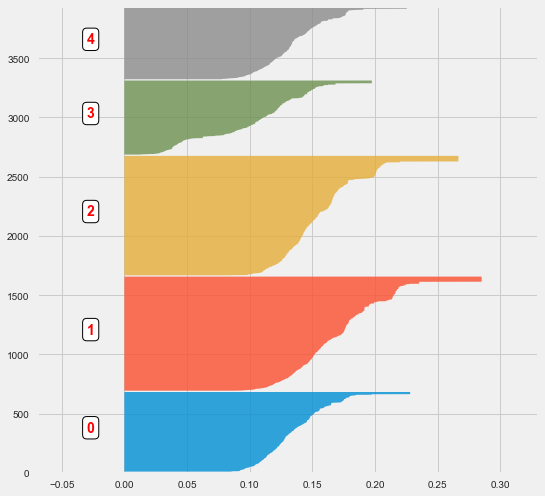

In [45]:
# define individual silouhette scores
sample_silhouette_values = silhouette_samples(matrix, clusters)

# and do the graph
graph_component_silhouette(n_clusters, [-0.07, 0.33], len(X), sample_silhouette_values, clusters)

plt.show()

In [46]:
# Word Cloud
# Now we can have a look at the type of objects that each cluster represents. 
#In order to obtain a global view of their contents, I determine which keywords are the most frequent in each of them

liste = pd.DataFrame(liste_produits)
liste_words = [word for (word, occurence) in list_products]

occurence = [dict() for _ in range(n_clusters)]

for i in range(n_clusters):
    liste_cluster = liste.loc[clusters == i]
    for word in liste_words:
        if word in ['art', 'set', 'heart', 'pink', 'blue', 'tag']: continue
        occurence[i][word] = sum(liste_cluster.loc[:, 0].str.contains(word.upper()))

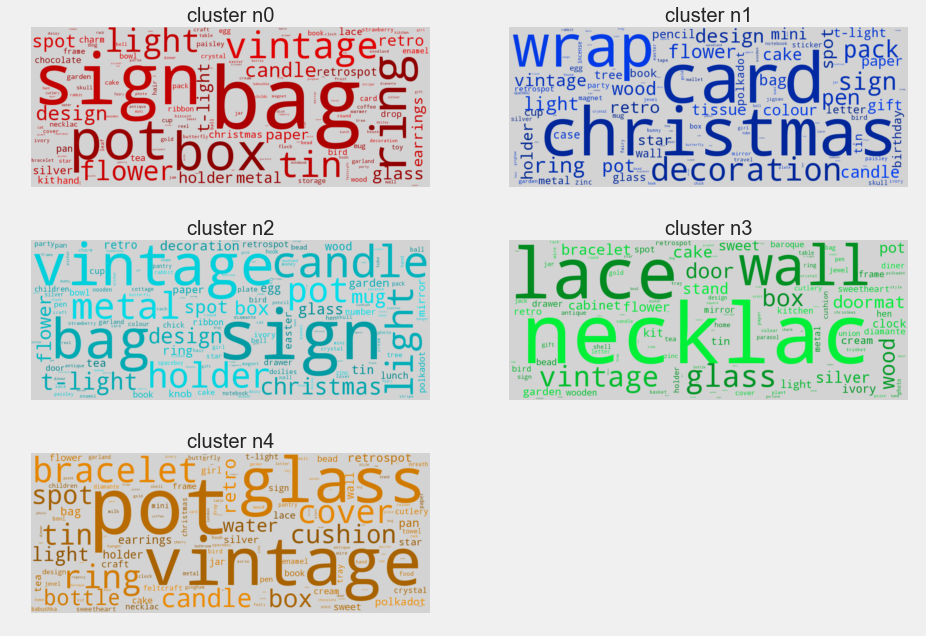

In [47]:
# and We output the result as wordclouds:

def random_color_func(word=None, font_size=None, position=None,
                      orientation=None, font_path=None, random_state=None):
    h = int(360.0 * tone / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(70, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)

def make_wordcloud(liste, increment):
    ax1 = fig.add_subplot(4,2,increment)
    words = dict()
    trunc_occurences = liste[0:150]
    for s in trunc_occurences:
        words[s[0]] = s[1]
    
    wordcloud = WordCloud(width=1000,height=400, background_color='lightgrey', 
                          max_words=1628,relative_scaling=1,
                          color_func = random_color_func,
                          normalize_plurals=False)
    wordcloud.generate_from_frequencies(words)
    ax1.imshow(wordcloud, interpolation="bilinear")
    ax1.axis('off')
    plt.title('cluster n{}'.format(increment-1))

fig = plt.figure(1, figsize=(14,14))
color = [0, 160, 130, 95, 280, 40, 330, 110, 25]
for i in range(n_clusters):
    list_cluster_occurences = occurence[i]

    tone = color[i] # define the color of the words
    liste = []
    for key, value in list_cluster_occurences.items():
        liste.append([key, value])
    liste.sort(key = lambda x:x[1], reverse = True)
    make_wordcloud(liste, i+1)
plt.show()



In [48]:
# From this representation, we can see that for example, one of the clusters contains objects that could be associated with gifts (keywords: Christmas, packaging, card, ...).
# Another cluster would rather contain luxury items and jewelry (keywords: necklace, bracelet, lace, silver, ...).
# Nevertheless, it can also be observed that many words appear in various clusters and it is therefore difficult to clearly distinguish them.

In [49]:
# Principal Component Analysis
# In order to ensure that these clusters are truly distinct, We look at their composition. Given the large number of variables of the initial matrix, We first perform a PCA:

pca = PCA()
pca.fit(matrix)
pca_samples = pca.transform(matrix)
    

C:\Users\me\Anaconda3\lib\site-packages\seaborn\categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


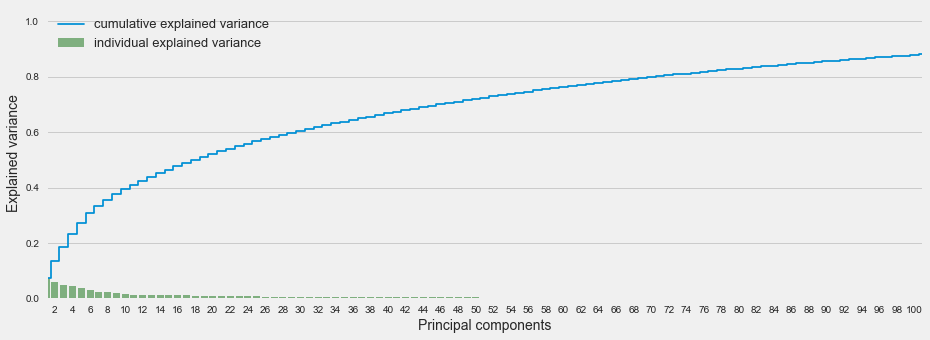

In [50]:
# and then check for the amount of variance explained by each component:
fig, ax = plt.subplots(figsize=(14, 5))
sns.set(font_scale=1)
plt.step(range(matrix.shape[1]), pca.explained_variance_ratio_.cumsum(), where='mid',
         label='cumulative explained variance')
sns.barplot(np.arange(1,matrix.shape[1]+1), pca.explained_variance_ratio_, alpha=0.5, color = 'g',
            label='individual explained variance')
plt.xlim(0, 100)

ax.set_xticklabels([s if int(s.get_text())%2 == 0 else '' for s in ax.get_xticklabels()])

plt.ylabel('Explained variance', fontsize = 14)
plt.xlabel('Principal components', fontsize = 14)
plt.legend(loc='upper left', fontsize = 13);
plt.show()


In [51]:
# We see that the number of components required to explain the data is extremely important:
# We need more than 100 components to explain 90% of the variance of the data
# In practice, 
# We decide to keep only a limited number of components since this decomposition is only performed to visualize the data:
pca = PCA(n_components=50)
matrix_9D = pca.fit_transform(matrix)
mat = pd.DataFrame(matrix_9D)
mat['cluster'] = pd.Series(clusters)

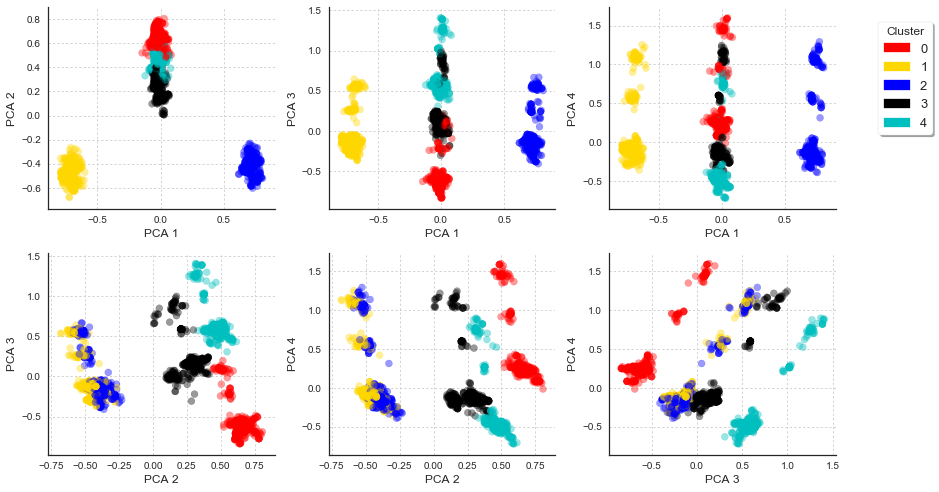

In [52]:
import matplotlib.patches as mpatches

sns.set_style("white")
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2.5})

LABEL_COLOR_MAP = {0:'r', 1:'gold', 2:'b', 3:'k', 4:'c', 5:'g'}
label_color = [LABEL_COLOR_MAP[l] for l in mat['cluster']]

fig = plt.figure(figsize = (12,10))
increment = 0
for ix in range(4):
    for iy in range(ix+1, 4):    
        increment += 1
        ax = fig.add_subplot(3,3,increment)
        ax.scatter(mat[ix], mat[iy], c= label_color, alpha=0.4) 
        plt.ylabel('PCA {}'.format(iy+1), fontsize = 12)
        plt.xlabel('PCA {}'.format(ix+1), fontsize = 12)
        ax.yaxis.grid(color='lightgray', linestyle=':')
        ax.xaxis.grid(color='lightgray', linestyle=':')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        
        if increment == 9: break
    if increment == 9: break
        

comp_handler = []
for i in range(5):
    comp_handler.append(mpatches.Patch(color = LABEL_COLOR_MAP[i], label = i))

plt.legend(handles=comp_handler, bbox_to_anchor=(1.1, 0.97), 
           title='Cluster',
           shadow = True, frameon = True, framealpha = 1,fontsize = 13, 
           bbox_transform = plt.gcf().transFigure) #facecolor = 'lightgrey',

plt.tight_layout()
plt.show()

In [53]:
# Customer categories
# Steps for generatin
## Formatting data
#### Grouping products
#### Splitting of the dataset
#### Grouping orders

##Creating customer categories
####Data encoding
####Creating categories



In [54]:
# Formatting data
# In the previous section, the different products were grouped in five clusters.
# In order to prepare the rest of the analysis, a first step consists in introducing this information into the dataframe.
# To do this, I create the categorical variable categ_product where I indicate the cluster of each product :

corresp = dict()
for key, val in zip (liste_produits, clusters):
    corresp[key] = val 

df_cleaned['categ_product'] = df_cleaned.loc[:, 'Description'].map(corresp)
df_cleaned[['InvoiceNo', 'Description', 
            'categ_product']][:10]

,InvoiceNo,Description,categ_product
0,536365,WHITE HANGING HEART T-LIGHT HOLDER,0
1,536365,WHITE METAL LANTERN,4
2,536365,CREAM CUPID HEARTS COAT HANGER,4
3,536365,KNITTED UNION FLAG HOT WATER BOTTLE,4
4,536365,RED WOOLLY HOTTIE WHITE HEART.,4
5,536365,SET 7 BABUSHKA NESTING BOXES,3
6,536365,GLASS STAR FROSTED T-LIGHT HOLDER,4
7,536366,HAND WARMER UNION JACK,0
8,536366,HAND WARMER RED POLKA DOT,2
9,536367,ASSORTED COLOUR BIRD ORNAMENT,2


In [55]:
# Grouping products
# In a second step, 
# We decide to create the categ_N variables (with $ N \in [0: 4]$) that contains the amount spent in each product category:

for i in range(5):
    col = 'categ_{}'.format(i)        
    df_temp = df_cleaned[df_cleaned['categ_product'] == i]
    price_temp = df_temp['UnitPrice'] * (df_temp['Quantity'] - df_temp['QuantityCanceled'])
    price_temp = price_temp.apply(lambda x:x if x > 0 else 0)
    df_cleaned.loc[:, col] = price_temp
    df_cleaned[col].fillna(0, inplace = True)


df_cleaned[['InvoiceNo', 'Description', 
            'categ_product', 'categ_0', 'categ_1', 'categ_2', 'categ_3','categ_4']][:10]

,InvoiceNo,Description,categ_product,categ_0,categ_1,categ_2,categ_3,categ_4
0,536365,WHITE HANGING HEART T-LIGHT HOLDER,0,15.3,0.0,0.00,0.0,0.00
1,536365,WHITE METAL LANTERN,4,0.0,0.0,0.00,0.0,20.34
2,536365,CREAM CUPID HEARTS COAT HANGER,4,0.0,0.0,0.00,0.0,22.00
3,536365,KNITTED UNION FLAG HOT WATER BOTTLE,4,0.0,0.0,0.00,0.0,20.34
4,536365,RED WOOLLY HOTTIE WHITE HEART.,4,0.0,0.0,0.00,0.0,20.34
5,536365,SET 7 BABUSHKA NESTING BOXES,3,0.0,0.0,0.00,15.3,0.00
6,536365,GLASS STAR FROSTED T-LIGHT HOLDER,4,0.0,0.0,0.00,0.0,25.50
7,536366,HAND WARMER UNION JACK,0,11.1,0.0,0.00,0.0,0.00
8,536366,HAND WARMER RED POLKA DOT,2,0.0,0.0,11.10,0.0,0.00
9,536367,ASSORTED COLOUR BIRD ORNAMENT,2,0.0,0.0,54.08,0.0,0.00


In [56]:
# Up to now, the information related to a single order was split over several lines of the dataframe (one line per product).
# We decide to collect the information related to a particular order and put in in a single entry.
# We therefore create a new dataframe that contains, for each order, the amount of the basket, as well as the way it is distributed over the 5 categories of products:



In [57]:
# sum of purchases / user & order
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['TotalPrice'].sum()
basket_price = temp.rename(columns = {'TotalPrice':'Basket Price'})

# percentage of the price of the order / product category
for i in range(5):
    col = 'categ_{}'.format(i) 
    temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)[col].sum()
    basket_price.loc[:, col] = temp 

# date of the order

df_cleaned['InvoiceDate_int'] = df_cleaned['InvoiceDate'].astype('int64')
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate_int'].mean()
df_cleaned.drop('InvoiceDate_int', axis = 1, inplace = True)
basket_price.loc[:, 'InvoiceDate'] = pd.to_datetime(temp['InvoiceDate_int'])

# selection of significant entries:
basket_price = basket_price[basket_price['Basket Price'] > 0]
basket_price.sort_values('CustomerID', ascending = True)[:5]

,CustomerID,InvoiceNo,Basket Price,categ_0,categ_1,categ_2,categ_3,categ_4,InvoiceDate
1,12347,537626,711.79,83.40,23.40,187.2,124.44,293.35,2010-12-07 14:57:00.000001024
2,12347,542237,475.39,53.10,84.34,130.5,38.25,169.20,2011-01-26 14:29:59.999999744
3,12347,549222,636.25,71.10,81.00,330.9,38.25,115.00,2011-04-07 10:42:59.999999232
4,12347,556201,382.52,78.06,41.40,74.4,19.90,168.76,2011-06-09 13:01:00.000000256
5,12347,562032,584.91,119.70,61.30,109.7,136.05,158.16,2011-08-02 08:48:00.000000000


In [58]:
# Splitting of data over time
# The dataframe basket_price contains information for a period of 12 months. 
# Later, one of the objectives will be to develop a model capable of characterizing and anticipating the habits of the customers visiting the site and this, from their first visit.
# In order to be able to test the model in a realistic way
#  We split the data set by retaining the first 10 months to develop the model and the following two months to test it:


print(basket_price['InvoiceDate'].min(), '->',  basket_price['InvoiceDate'].max())




2010-12-01 08:26:00 -> 2011-12-09 12:50:00


In [59]:
set_entrainement = basket_price[basket_price['InvoiceDate'] < datetime.date(2011,10,1)]
set_test         = basket_price[basket_price['InvoiceDate'] >= datetime.date(2011,10,1)]
basket_price = set_entrainement.copy(deep = True)

C:\Users\me\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
  if __name__ == '__main__':
C:\Users\me\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
  from ipykernel import kernelapp as app


In [60]:
# Consumer Order Combinations
# In a second step, I group together the different entries that correspond to the same user.
# I thus determine the number of purchases made by the user, as well as the minimum, maximum, average amounts and the total amount spent during all the visits:

# of visits and stats on cart amount / users
transactions_per_user=basket_price.groupby(by=['CustomerID'])['Basket Price'].agg(['count','min',
                                                                                   'max','mean','sum'])
for i in range(5):
    col = 'categ_{}'.format(i)
    transactions_per_user.loc[:,col] = basket_price.groupby(by=['CustomerID'])[col].sum() /\
                                            transactions_per_user['sum']*100

transactions_per_user.reset_index(drop = False, inplace = True)
basket_price.groupby(by=['CustomerID'])['categ_0'].sum()
transactions_per_user.sort_values('CustomerID', ascending = True)[:5]

,CustomerID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4
0,12347,5,382.52,711.79,558.172000,2790.86,14.524555,10.442659,29.836681,12.787815,32.408290
1,12348,4,227.44,892.80,449.310000,1797.24,0.000000,38.016069,41.953217,20.030714,0.000000
2,12350,1,334.40,334.40,334.400000,334.40,27.900718,11.692584,48.444976,11.961722,0.000000
3,12352,6,144.35,840.30,345.663333,2073.98,3.370331,0.491808,12.892120,67.534402,15.711338
4,12353,1,89.00,89.00,89.000000,89.00,19.887640,0.000000,13.033708,67.078652,0.000000


In [61]:
# Finally, We define two additional variables that give the number of days elapsed since the first purchase ( FirstPurchase ) 
# The number of days since the last purchase ( LastPurchase ):

last_date = basket_price['InvoiceDate'].max().date()

first_registration = pd.DataFrame(basket_price.groupby(by=['CustomerID'])['InvoiceDate'].min())
last_purchase      = pd.DataFrame(basket_price.groupby(by=['CustomerID'])['InvoiceDate'].max())

test  = first_registration.applymap(lambda x:(last_date - x.date()).days)
test2 = last_purchase.applymap(lambda x:(last_date - x.date()).days)

transactions_per_user.loc[:, 'LastPurchase'] = test2.reset_index(drop = False)['InvoiceDate']
transactions_per_user.loc[:, 'FirstPurchase'] = test.reset_index(drop = False)['InvoiceDate']

transactions_per_user[:5]


,CustomerID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4,LastPurchase,FirstPurchase
0,12347,5,382.52,711.79,558.172000,2790.86,14.524555,10.442659,29.836681,12.787815,32.408290,59,297
1,12348,4,227.44,892.80,449.310000,1797.24,0.000000,38.016069,41.953217,20.030714,0.000000,5,288
2,12350,1,334.40,334.40,334.400000,334.40,27.900718,11.692584,48.444976,11.961722,0.000000,240,240
3,12352,6,144.35,840.30,345.663333,2073.98,3.370331,0.491808,12.892120,67.534402,15.711338,2,226
4,12353,1,89.00,89.00,89.000000,89.00,19.887640,0.000000,13.033708,67.078652,0.000000,134,134


In [62]:
# A customer category of particular interest is that of customers who make only one purchase. 
# One of the objectives may be, for example, to target these customers in order to retain them.
# In part, I find that this type of customer represents 1/3 of the customers listed:

n1 = transactions_per_user[transactions_per_user['count'] == 1].shape[0]
n2 = transactions_per_user.shape[0]
print("No. customers with single purchase: {:<2}/{:<5} ({:<2.2f}%)".format(n1,n2,n1/n2*100))

No. customers with single purchase: 1445/3608  (40.05%)


In [63]:
# Creation of customers categories
# Data encoding
# The dataframe transactions_per_user contains a summary of all the commands that were made. 
# Each entry in this dataframe corresponds to a particular client. 
# I use this information to characterize the different types of customers and only keep a subset of variables:

list_cols = ['count','min','max','mean','categ_0','categ_1','categ_2','categ_3','categ_4']
#_____________________________________________________________
selected_customers = transactions_per_user.copy(deep = True)
matrix = selected_customers[list_cols].as_matrix()

C:\Users\me\Anaconda3\lib\site-packages\ipykernel\__main__.py:10: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [64]:
# In practice, the different variables We selected have quite different ranges of variation and before continuing the analysis, We create a matrix where these data are standardized:
scaler = StandardScaler()
scaler.fit(matrix)
print('variables mean values: \n' + 90*'-' + '\n' , scaler.mean_)
scaled_matrix = scaler.transform(matrix)

variables mean values: 
------------------------------------------------------------------------------------------
 [  3.62305987 259.93189634 556.26687999 377.06036244  21.19884856
  13.98907929  25.22916919  23.21847344  16.37327913]


In [65]:
# In the following, I will create clusters of customers. In practice, before creating these clusters
# It is interesting to define a base of smaller dimension allowing to describe the scaled_matrix matrix.
# In this case, We will use this base in order to create a representation of the different clusters and thus verify the quality of the separation of the different groups.

pca = PCA()
pca.fit(scaled_matrix)
pca_samples = pca.transform(scaled_matrix)


C:\Users\me\Anaconda3\lib\site-packages\seaborn\categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


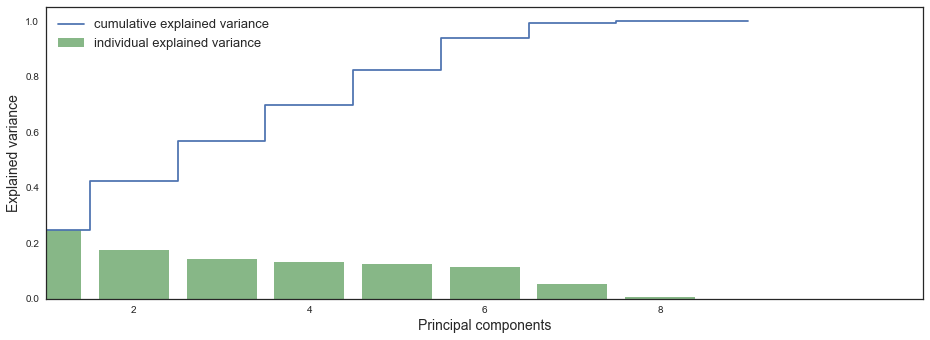

In [66]:
#  We represent the amount of variance explained by each of the components:
fig, ax = plt.subplots(figsize=(14, 5))
sns.set(font_scale=1)
plt.step(range(matrix.shape[1]), pca.explained_variance_ratio_.cumsum(), where='mid',
         label='cumulative explained variance')
sns.barplot(np.arange(1,matrix.shape[1]+1), pca.explained_variance_ratio_, alpha=0.5, color = 'g',
            label='individual explained variance')
plt.xlim(0, 10)

ax.set_xticklabels([s if int(s.get_text())%2 == 0 else '' for s in ax.get_xticklabels()])

plt.ylabel('Explained variance', fontsize = 14)
plt.xlabel('Principal components', fontsize = 14)
plt.legend(loc='best', fontsize = 13);
plt.show()



In [67]:
# Creating customer categories
# At this point, We define clusters of clients from the standardized matrix that was defined earlier and using the k-means algorithm fromscikit-learn.
# We choose the number of clusters based on the silhouette score and I find that the best score is obtained with 11 clusters:

n_clusters = 11
kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=100)
kmeans.fit(scaled_matrix)
clusters_clients = kmeans.predict(scaled_matrix)
silhouette_avg = silhouette_score(scaled_matrix, clusters_clients)
print('silhouette score: {:<.3f}'.format(silhouette_avg))

silhouette score: 0.217


In [68]:
# At first, I look at the number of customers in each cluster:
pd.DataFrame(pd.Series(clusters_clients).value_counts(), columns = ['number of clients']).T

,0,10,6,7,1,4,2,3,8,5,9
number of clients,1463,508,466,290,287,231,185,151,12,8,7


In [69]:
pca = PCA(n_components=6)
matrix_3D = pca.fit_transform(scaled_matrix)
mat = pd.DataFrame(matrix_3D)
mat['cluster'] = pd.Series(clusters_clients)

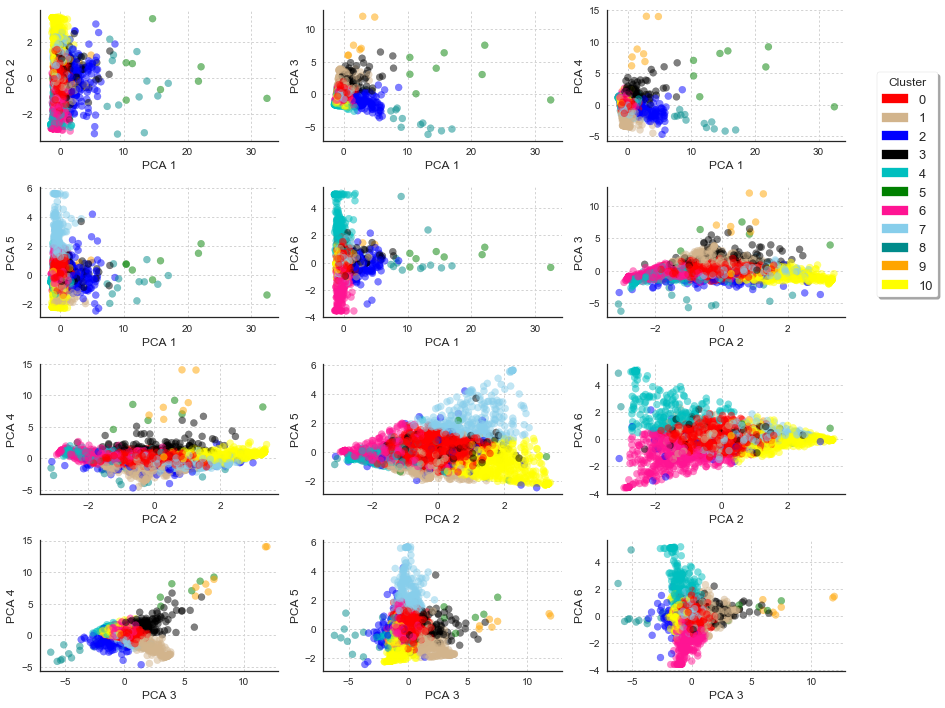

In [70]:
import matplotlib.patches as mpatches

sns.set_style("white")
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2.5})

LABEL_COLOR_MAP = {0:'r', 1:'tan', 2:'b', 3:'k', 4:'c', 5:'g', 6:'deeppink', 7:'skyblue', 8:'darkcyan',
                   9:'orange',
                   10:'yellow', 11:'tomato', 12:'seagreen'}
label_color = [LABEL_COLOR_MAP[l] for l in mat['cluster']]

fig = plt.figure(figsize = (12,10))
increment = 0
for ix in range(6):
    for iy in range(ix+1, 6):   
        increment += 1
        ax = fig.add_subplot(4,3,increment)
        ax.scatter(mat[ix], mat[iy], c= label_color, alpha=0.5) 
        plt.ylabel('PCA {}'.format(iy+1), fontsize = 12)
        plt.xlabel('PCA {}'.format(ix+1), fontsize = 12)
        ax.yaxis.grid(color='lightgray', linestyle=':')
        ax.xaxis.grid(color='lightgray', linestyle=':')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        
        if increment == 12: break
    if increment == 12: break
        
#_______________________________________________
# I set the legend: abreviation -> airline name
comp_handler = []
for i in range(n_clusters):
    comp_handler.append(mpatches.Patch(color = LABEL_COLOR_MAP[i], label = i))

plt.legend(handles=comp_handler, bbox_to_anchor=(1.1, 0.9), 
           title='Cluster', 
           shadow = True, frameon = True, framealpha = 1,
           fontsize = 13, bbox_transform = plt.gcf().transFigure) #facecolor = 'lightgrey',

plt.tight_layout()
plt.show()

In [71]:
# observation
# From this representation, it can be seen, for example, that the first principal component allow to separate the tiniest clusters from the rest. 
# More generally, we see that there is always a representation in which two clusters will appear to be distinct.

In [72]:
# Score of the silhouette intra-cluster
# As with product categories, another way to look at the quality of the separation is to look at silouhette scores within different clusters:
sample_silhouette_values = silhouette_samples(scaled_matrix, clusters_clients)
#____________________________________
# define individual silhouette scores 
sample_silhouette_values = silhouette_samples(scaled_matrix, clusters_clients)
#__________________
# and do the graph
graph_component_silhouette(n_clusters, [-0.15, 0.55], len(scaled_matrix), sample_silhouette_values, 
                           clusters_clients)


In [73]:
# Customers morphotype
# At this stage, We have verified that the different clusters are indeed disjoint (at least, in a global way).
# It remains to understand the habits of the customers in each cluster.
# To do so, We start by adding to the selected_customers dataframe a variable that defines the cluster to which each client belongs:

selected_customers.loc[:, 'cluster'] = clusters_clients

In [74]:
# Then, We average the contents of this dataframe by first selecting the different groups of clients. 
# This gives access to, for example, the average baskets price, the number of visits or the total sums spent by the clients of the different clusters.
# We also determine the number of clients in each group (variable size ):

merged_df = pd.DataFrame()
for i in range(n_clusters):
    test = pd.DataFrame(selected_customers[selected_customers['cluster'] == i].mean())
    test = test.T.set_index('cluster', drop = True)
    test['size'] = selected_customers[selected_customers['cluster'] == i].shape[0]
    merged_df = pd.concat([merged_df, test])
#_____________________________________________________
merged_df.drop('CustomerID', axis = 1, inplace = True)
print('number of customers:', merged_df['size'].sum())

merged_df = merged_df.sort_values('sum')

number of customers: 3608


In [75]:
# Finally, I re-organize the content of the dataframe by ordering the different clusters: 
# first, in relation to the amount wpsent in each product category and then, according to the total amount spent:

liste_index = []
for i in range(5):
    column = 'categ_{}'.format(i)
    liste_index.append(merged_df[merged_df[column] > 45].index.values[0])

liste_index_reordered = liste_index
liste_index_reordered += [ s for s in merged_df.index if s not in liste_index]

merged_df = merged_df.reindex(index = liste_index_reordered)
merged_df = merged_df.reset_index(drop = False)
display(merged_df[['cluster', 'count', 'min', 'max', 'mean', 'sum', 'categ_0',
                   'categ_1', 'categ_2', 'categ_3', 'categ_4', 'size']])


,cluster,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4,size
0,1.0,2.578397,211.335679,375.124774,288.734799,812.509652,61.314523,6.988318,14.810284,10.015622,6.871253,287
1,4.0,2.199134,193.774026,317.699913,247.165261,582.228312,11.101421,57.570041,18.052858,7.249538,6.026141,231
2,6.0,2.454936,213.901824,332.311075,269.482427,676.670260,12.833347,12.807978,57.044069,9.567472,7.750328,466
3,10.0,2.614173,199.237935,345.103130,261.898516,709.880415,10.873377,4.775956,11.079477,62.325559,10.956740,508
4,7.0,2.131034,202.623310,335.110552,262.189665,649.416207,13.528824,6.326378,13.455483,15.323963,51.418763,290
5,0.0,3.265892,218.835414,457.609338,329.838043,1088.385859,22.293538,13.957412,25.568039,20.706652,17.478410,1463
6,2.0,1.713514,1045.358811,1410.539357,1210.316878,2199.384330,21.307045,12.064006,26.176823,23.229542,17.222949,185
7,8.0,1.666667,3480.920833,3966.812500,3700.139306,5949.600000,13.322062,22.890736,20.102624,28.513409,15.171169,12
8,3.0,18.443709,87.924503,1704.021589,588.036388,10345.026954,25.311837,12.303104,24.034537,22.200607,16.170667,151
9,9.0,92.000000,10.985714,1858.250000,374.601553,34845.105714,22.527857,13.117583,25.832531,25.144909,13.402971,7


In [76]:
# Customers morphology garphical representation
# Finally, We created a representation of the different morphotypes. To do this, I define a class to create "Radar Charts"

def _scale_data(data, ranges):
    (x1, x2) = ranges[0]
    d = data[0]
    return [(d - y1) / (y2 - y1) * (x2 - x1) + x1 for d, (y1, y2) in zip(data, ranges)]

class RadarChart():
    def __init__(self, fig, location, sizes, variables, ranges, n_ordinate_levels = 6):

        angles = np.arange(0, 360, 360./len(variables))

        ix, iy = location[:] ; size_x, size_y = sizes[:]
        
        axes = [fig.add_axes([ix, iy, size_x, size_y], polar = True, 
        label = "axes{}".format(i)) for i in range(len(variables))]

        _, text = axes[0].set_thetagrids(angles, labels = variables)
        
        for txt, angle in zip(text, angles):
            if angle > -1 and angle < 181:
                txt.set_rotation(angle - 90)
            else:
                txt.set_rotation(angle - 270)
        
        for ax in axes[1:]:
            ax.patch.set_visible(False)
            ax.xaxis.set_visible(False)
            ax.grid("off")
        
        for i, ax in enumerate(axes):
            grid = np.linspace(*ranges[i],num = n_ordinate_levels)
            grid_label = [""]+["{:.0f}".format(x) for x in grid[1:-1]]
            ax.set_rgrids(grid, labels = grid_label, angle = angles[i])
            ax.set_ylim(*ranges[i])
        
        self.angle = np.deg2rad(np.r_[angles, angles[0]])
        self.ranges = ranges
        self.ax = axes[0]
                
    def plot(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.plot(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

    def fill(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.fill(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

    def legend(self, *args, **kw):
        self.ax.legend(*args, **kw)
        
    def title(self, title, *args, **kw):
        self.ax.text(0.9, 1, title, transform = self.ax.transAxes, *args, **kw)


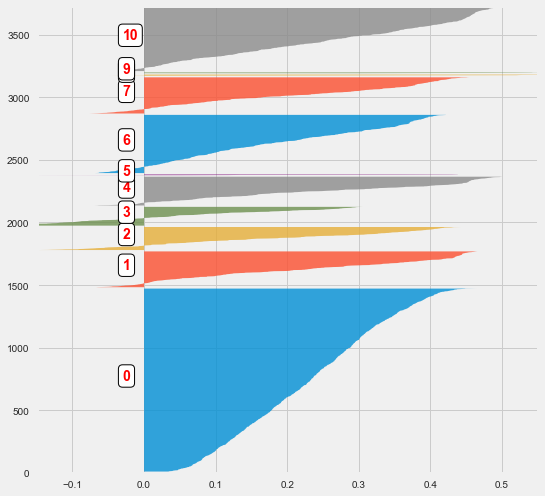

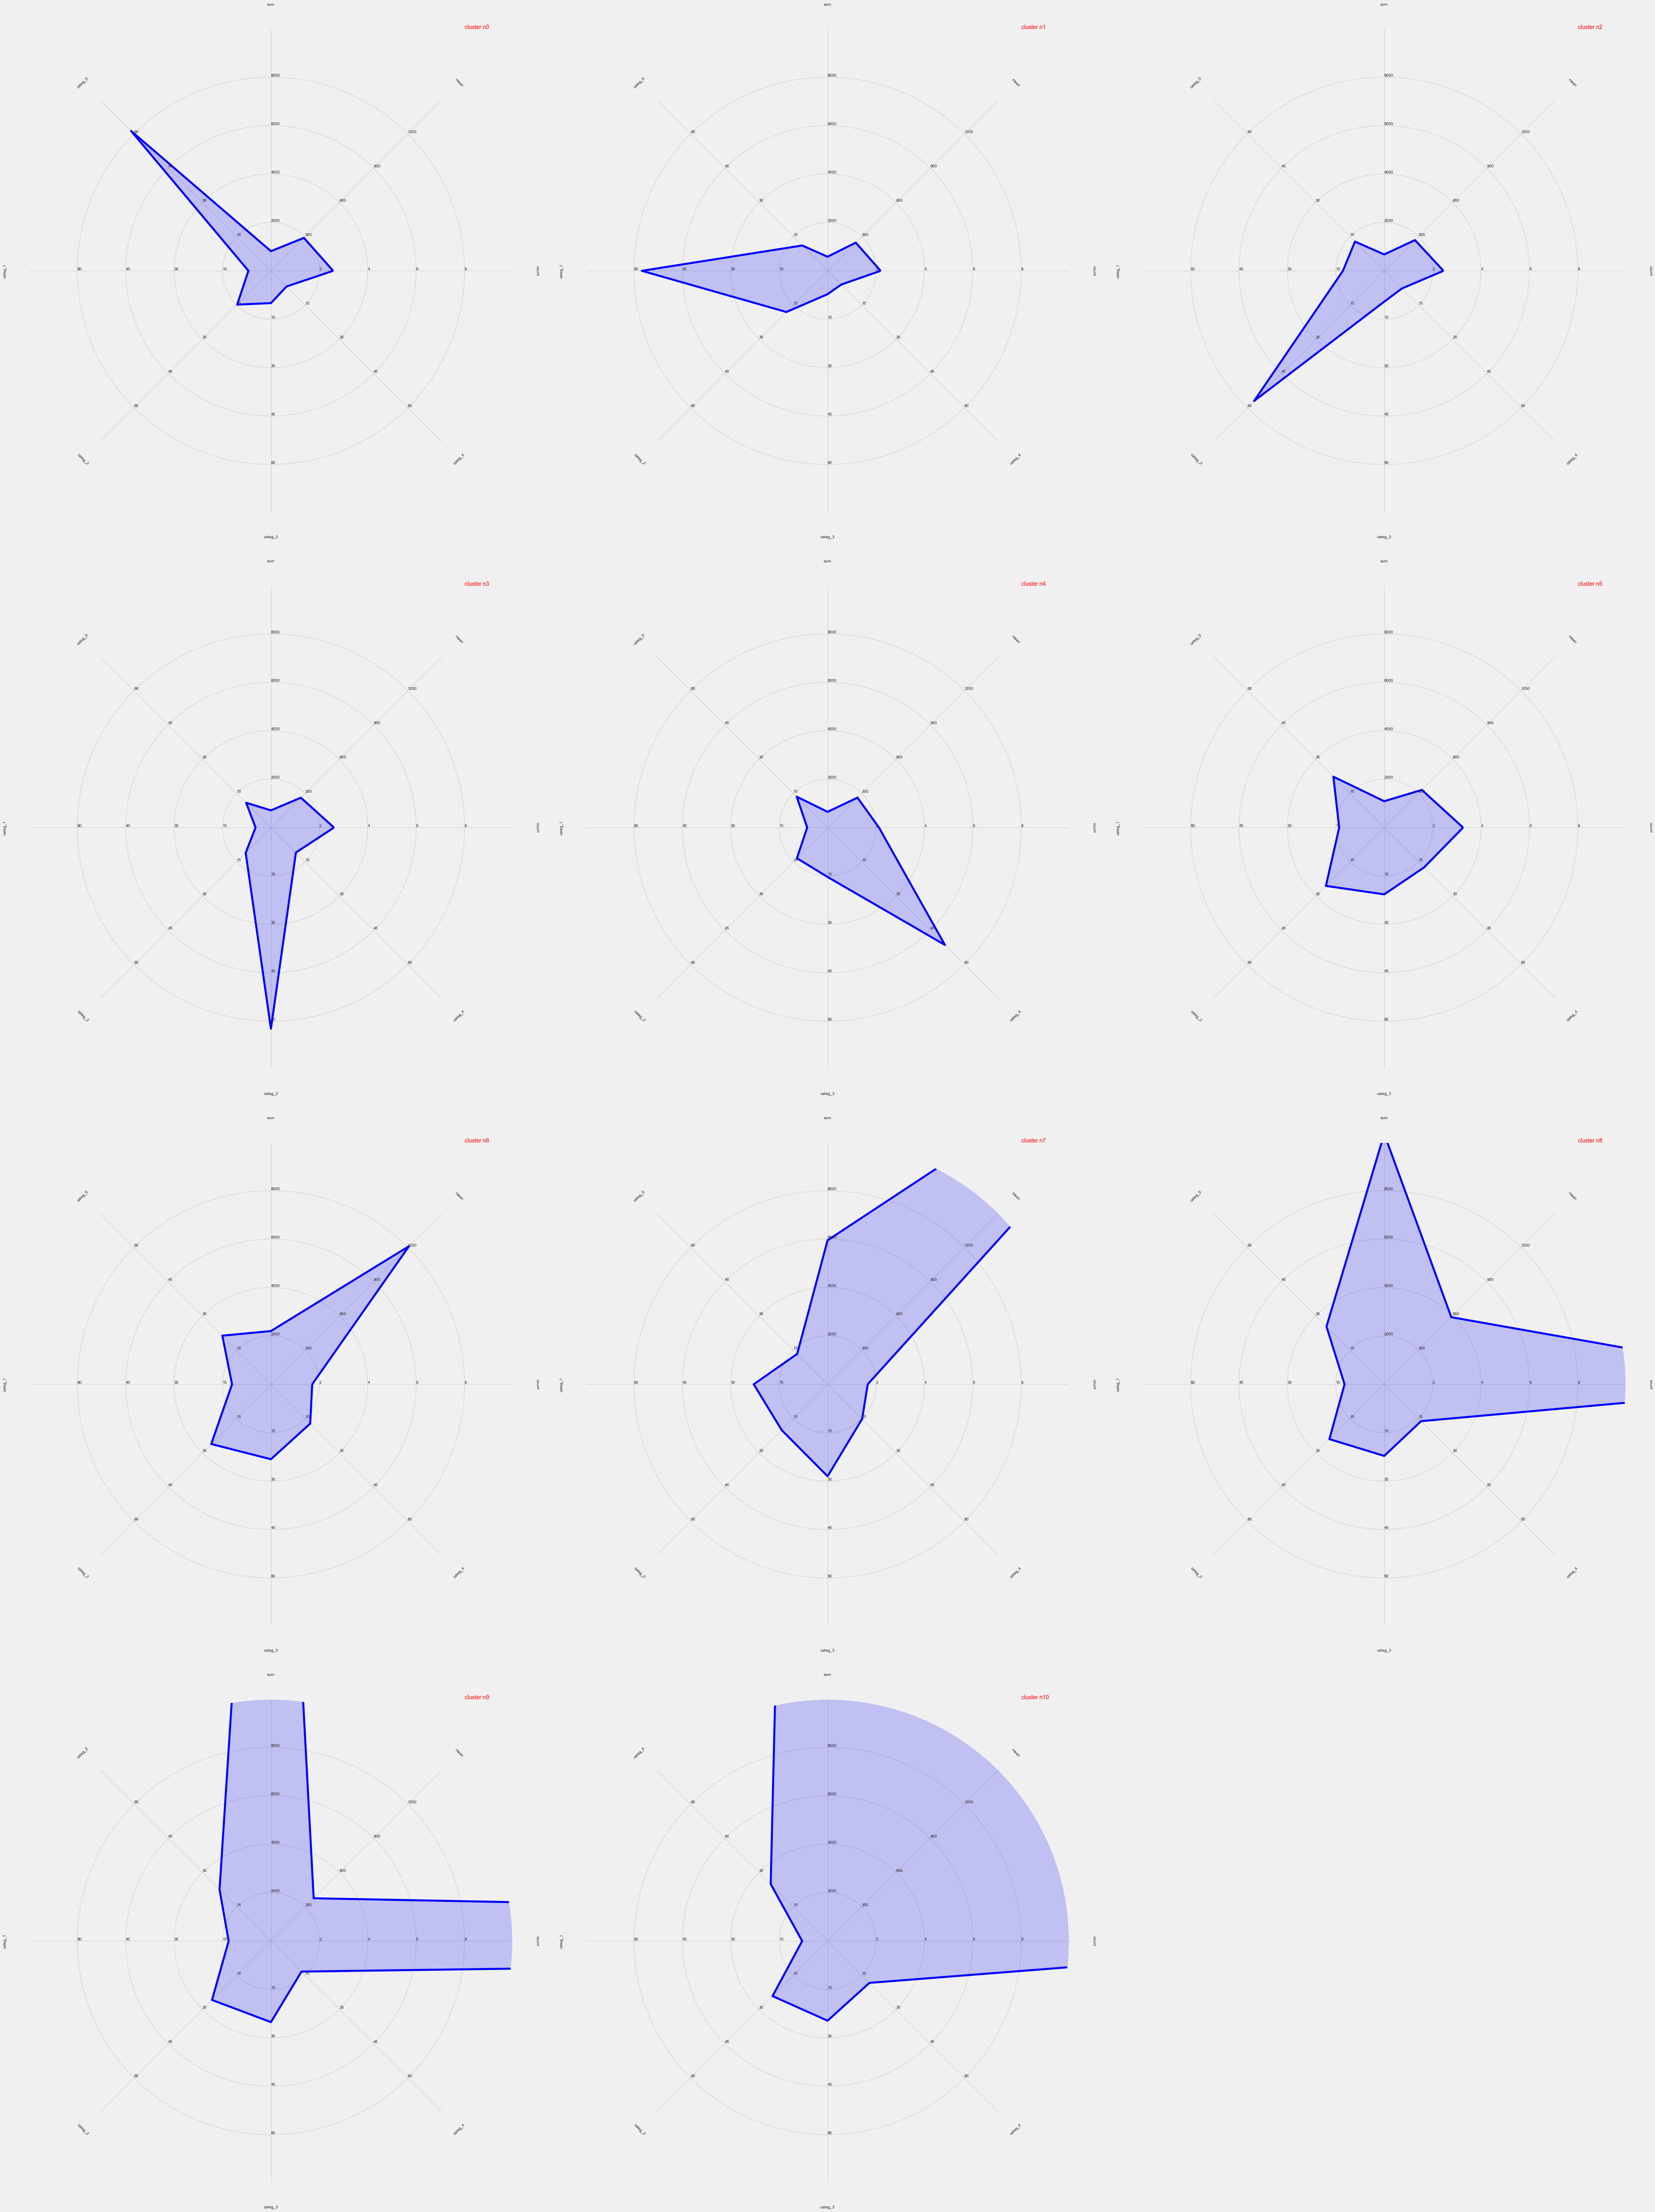

In [77]:
# This allows to have a global view of the content of each cluster:

fig = plt.figure(figsize=(50,50))

attributes = ['count', 'mean', 'sum', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4']
ranges = [[0.01, 10], [0.01, 1500], [0.01, 10000], [0.01, 75], [0.01, 75], [0.01, 75], [0.01, 75], [0.01, 75]]
index  = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

n_groups = n_clusters ; i_cols = 3
i_rows = n_groups//i_cols
size_x, size_y = (1/i_cols), (1/i_rows)

for ind in range(n_clusters):
    ix = ind%3 ; iy = i_rows - ind//3
    pos_x = ix*(size_x + 0.05) ; pos_y = iy*(size_y + 0.05)            
    location = [pos_x, pos_y]  ; sizes = [size_x, size_y] 
    #______________________________________________________
    data = np.array(merged_df.loc[index[ind], attributes])  
    #print (data)
    radar = RadarChart(fig, location, sizes, attributes, ranges)
    radar.plot(data, color = 'b', linewidth=5.0)
    radar.fill(data, alpha = 0.2, color = 'b')
    radar.title(title = 'cluster n{}'.format(index[ind]), color = 'r')
    ind += 1
plt.show()


In [78]:
# Observation 
# It can be seen, for example, that the first 5 clusters correspond to a strong preponderance of purchases in a particular category of products.
# Other clusters will differ from basket averages ( mean ), the total sum spent by the clients ( sum ) or the total number of visits made ( count ).

In [79]:
# Classification of customers
# In this part, the objective will be to adjust a classifier that will classify consumers in the different client categories that were established in the previous section.
# The objective is to make this classification possible at the first visit. To fulfill this objective, I will test several classifiers implemented in scikit-learn.

In [80]:
class Class_Fit(object):
    def __init__(self, clf, params=None):
        if params:            
            self.clf = clf(**params)
        else:
            self.clf = clf()

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def grid_search(self, parameters, Kfold):
        self.grid = GridSearchCV(estimator = self.clf, param_grid = parameters, cv = Kfold)
        
    def grid_fit(self, X, Y):
        self.grid.fit(X, Y)
        
    def grid_predict(self, X, Y):
        self.predictions = self.grid.predict(X)
        print("Precision: {:.2f} % ".format(100*metrics.accuracy_score(Y, self.predictions)))

In [81]:
# Since the goal is to define the class to which a client belongs and this, as soon as its first visit
#  I only keep the variables that describe the content of the basket
#  not take into account the variables related to the frequency of visits or variations of the basket price over time:

selected_customers.head()


,CustomerID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4,LastPurchase,FirstPurchase,cluster
0,12347,5,382.52,711.79,558.172000,2790.86,14.524555,10.442659,29.836681,12.787815,32.408290,59,297,0
1,12348,4,227.44,892.80,449.310000,1797.24,0.000000,38.016069,41.953217,20.030714,0.000000,5,288,6
2,12350,1,334.40,334.40,334.400000,334.40,27.900718,11.692584,48.444976,11.961722,0.000000,240,240,6
3,12352,6,144.35,840.30,345.663333,2073.98,3.370331,0.491808,12.892120,67.534402,15.711338,2,226,10
4,12353,1,89.00,89.00,89.000000,89.00,19.887640,0.000000,13.033708,67.078652,0.000000,134,134,10


In [82]:
columns = ['mean', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4' ]
X = selected_customers[columns]
Y = selected_customers['cluster']


In [83]:
# Finally, I split the dataset in train and test sets:
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, train_size = 0.8)

In [84]:
# Support Vector Machine Classifier (SVC)
# The first classifier We use is the SVC classifier. 
# In order to use it, We create an instance of the Class_Fit class and then callgrid_search().When calling this method, We provide as parameters:

##the hyperparameters for which I will seek an optimal value
##the number of folds to be used for cross-validation



In [85]:
svc = Class_Fit(clf = svm.LinearSVC)
svc.grid_search(parameters = [{'C':np.logspace(-2,2,10)}], Kfold = 5)


In [86]:
# Once this instance is created, We adjust the classifier to the training data:
svc.grid_fit(X = X_train, Y = Y_train)

In [87]:
# then We can test the quality of the prediction with respect to the test data:
svc.grid_predict(X_test, Y_test)

Precision: 80.89 % 


In [88]:
# Confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)
   
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    #_________________________________________________
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
plt.show()

Confusion matrix, without normalization


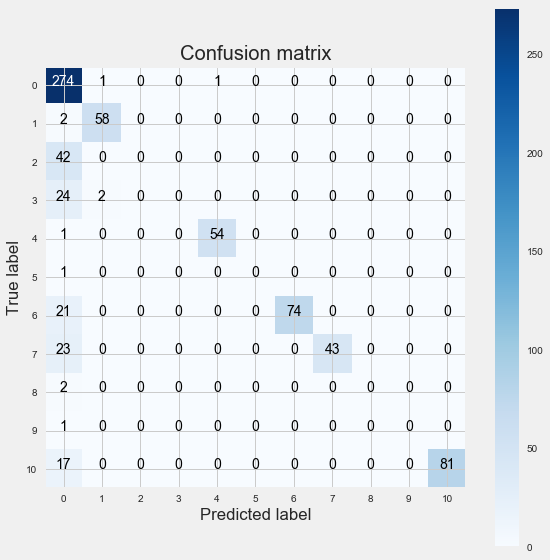

In [89]:
# from which I create the following representation:
class_names = [i for i in range(11)]
cnf_matrix = confusion_matrix(Y_test, svc.predictions) 
np.set_printoptions(precision=2)
plt.figure(figsize = (8,8))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize = False, title='Confusion matrix')
plt.show()


In [90]:
# Learning curve
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 10)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    return plt
plt.show()

C:\Users\me\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:811: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(train_sizes_abs.dtype, np.float):


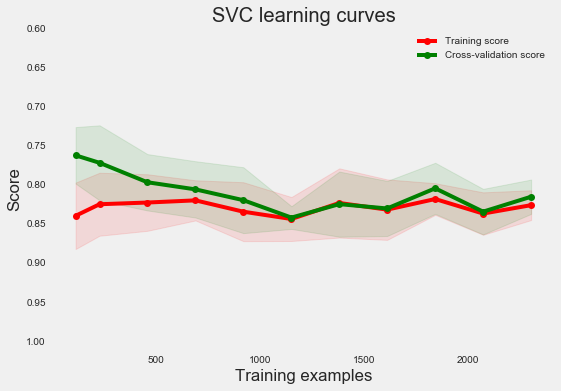

In [91]:
# from which I represent the leanring curve of the SVC classifier:

g = plot_learning_curve(svc.grid.best_estimator_,
                        "SVC learning curves", X_train, Y_train, ylim = [1.01, 0.6],
                        cv = 5,  train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5,
                                                0.6, 0.7, 0.8, 0.9, 1])
plt.show()


In [92]:
# Observation
# On this curve, we can see that the train and cross-validation curves converge towards the same limit when the sample size increases.
# This is typical of modeling with low variance and proves that the model does not suffer from overfitting.
# Also, we can see that the accuracy of the training curve is correct which is synonymous of a low bias.
# Hence the model does not underfit the data.

In [93]:
# Revised approach
# Logistic Regression
# I now consider the logistic regression classifier. 
lr = Class_Fit(clf = linear_model.LogisticRegression)
lr.grid_search(parameters = [{'C':np.logspace(-2,2,20)}], Kfold = 5)
lr.grid_fit(X = X_train, Y = Y_train)
lr.grid_predict(X_test, Y_test)


Precision: 87.95 % 


C:\Users\me\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:811: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(train_sizes_abs.dtype, np.float):


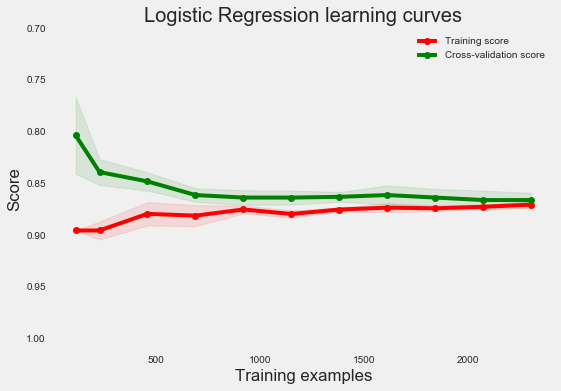

In [94]:
# Then, We plot the learning curve to have a feeling of the quality of the model:
g = plot_learning_curve(lr.grid.best_estimator_, "Logistic Regression learning curves", X_train, Y_train,
                        ylim = [1.01, 0.7], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

plt.show()

In [95]:
# k-Nearest Neighbors
knn = Class_Fit(clf = neighbors.KNeighborsClassifier)
knn.grid_search(parameters = [{'n_neighbors': np.arange(1,50,1)}], Kfold = 5)
knn.grid_fit(X = X_train, Y = Y_train)
knn.grid_predict(X_test, Y_test)

Precision: 78.67 % 


C:\Users\me\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:811: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(train_sizes_abs.dtype, np.float):


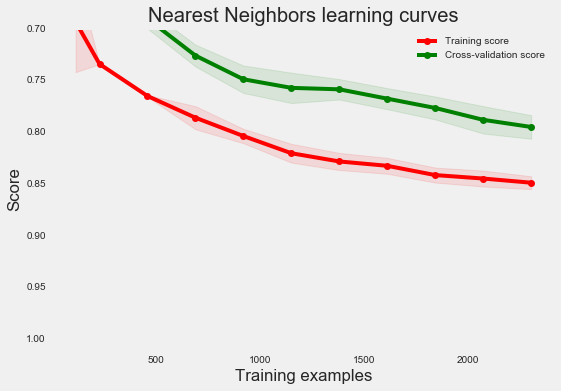

In [96]:
g = plot_learning_curve(knn.grid.best_estimator_, "Nearest Neighbors learning curves", X_train, Y_train,
                        ylim = [1.01, 0.7], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
plt.show()

In [97]:
# Decision Tree
tr = Class_Fit(clf = tree.DecisionTreeClassifier)
tr.grid_search(parameters = [{'criterion' : ['entropy', 'gini'], 'max_features' :['sqrt', 'log2']}], Kfold = 5)
tr.grid_fit(X = X_train, Y = Y_train)
tr.grid_predict(X_test, Y_test)


Precision: 83.24 % 


C:\Users\me\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:811: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(train_sizes_abs.dtype, np.float):


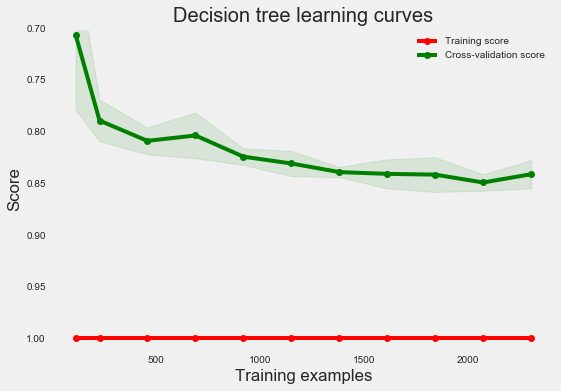

In [98]:
g = plot_learning_curve(tr.grid.best_estimator_, "Decision tree learning curves", X_train, Y_train,
                        ylim = [1.01, 0.7], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
plt.show()

In [99]:
# Random Forest
rf = Class_Fit(clf = ensemble.RandomForestClassifier)
param_grid = {'criterion' : ['entropy', 'gini'], 'n_estimators' : [20, 40, 60, 80, 100],
               'max_features' :['sqrt', 'log2']}
rf.grid_search(parameters = param_grid, Kfold = 5)
rf.grid_fit(X = X_train, Y = Y_train)
rf.grid_predict(X_test, Y_test)

Precision: 91.27 % 


C:\Users\me\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:811: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(train_sizes_abs.dtype, np.float):


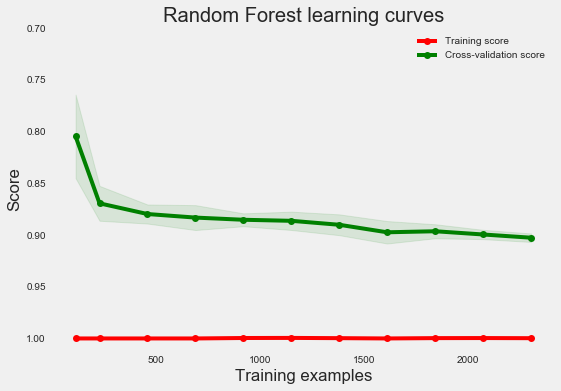

In [100]:
g = plot_learning_curve(rf.grid.best_estimator_, "Random Forest learning curves", X_train, Y_train,
                        ylim = [1.01, 0.7], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
plt.show()

In [101]:
# AdaBoost Classifier
ada = Class_Fit(clf = AdaBoostClassifier)
param_grid = {'n_estimators' : [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}
ada.grid_search(parameters = param_grid, Kfold = 5)
ada.grid_fit(X = X_train, Y = Y_train)
ada.grid_predict(X_test, Y_test)

Precision: 51.39 % 


C:\Users\me\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:811: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(train_sizes_abs.dtype, np.float):


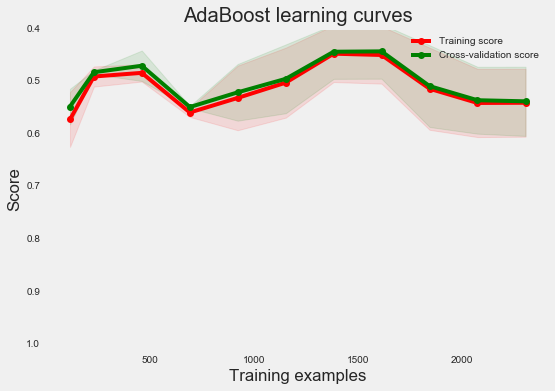

In [102]:
g = plot_learning_curve(ada.grid.best_estimator_, "AdaBoost learning curves", X_train, Y_train,
                        ylim = [1.01, 0.4], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
plt.show()

In [103]:
# Gradient Boosting Classifier
gb = Class_Fit(clf = ensemble.GradientBoostingClassifier)
param_grid = {'n_estimators' : [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}
gb.grid_search(parameters = param_grid, Kfold = 5)
gb.grid_fit(X = X_train, Y = Y_train)
gb.grid_predict(X_test, Y_test)

Precision: 90.30 % 


C:\Users\me\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:811: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(train_sizes_abs.dtype, np.float):


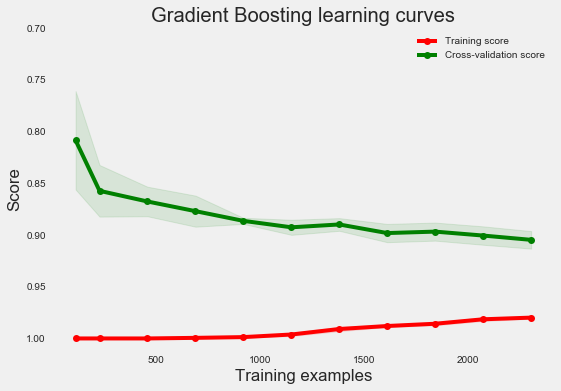

In [104]:
g = plot_learning_curve(gb.grid.best_estimator_, "Gradient Boosting learning curves", X_train, Y_train,
                        ylim = [1.01, 0.7], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
plt.show()

In [105]:
#Best approach

# Finally, the results of the different classifiers presented in the previous sections can be combined to improve the classification model. This can be achieved by selecting the customer category as the one indicated by the majority of classifiers.
# To do this, I use the VotingClassifier method of the sklearn package. 
# As a first step, I adjust the parameters of the various classifiers using the best parameters previously found:

rf_best  = ensemble.RandomForestClassifier(**rf.grid.best_params_)
gb_best  = ensemble.GradientBoostingClassifier(**gb.grid.best_params_)
svc_best = svm.LinearSVC(**svc.grid.best_params_)
tr_best  = tree.DecisionTreeClassifier(**tr.grid.best_params_)
knn_best = neighbors.KNeighborsClassifier(**knn.grid.best_params_)
lr_best  = linear_model.LogisticRegression(**lr.grid.best_params_)

In [106]:
# Then, I define a classifier that merges the results of the various classifiers:
votingC = ensemble.VotingClassifier(estimators=[('rf', rf_best),('gb', gb_best),
                                                ('knn', knn_best)], voting='soft')

In [107]:
# train it:
votingC = votingC.fit(X_train, Y_train)


In [108]:
# Finally, we can create a prediction for this model:
predictions = votingC.predict(X_test)
print("Precision: {:.2f} % ".format(100*metrics.accuracy_score(Y_test, predictions)))

Precision: 91.00 % 


C:\Users\me\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [109]:
## Note that when defining the votingC classifier
# I only used a sub-sample of the whole set of classifiers defined above and only retained the Random Forest, the k-Nearest Neighbors and the Gradient Boosting classifiers. 

In [110]:
# Testing predictions
# In the previous section, a few classifiers were trained in order to categorize customers. 
# Until that point, the whole analysis was based on the data of the first 10 months.
# In this section, I test the model the last two months of the dataset, that has been stored in the set_test dataframe:

basket_price = set_test.copy(deep = True)

In [111]:
# In a first step, I regroup reformattes these data according to the same procedure as used on the training set.
# However, I am correcting the data to take into account the difference in time between the two datasets and weights the variables count and sum to obtain an equivalence with the training set:
transactions_per_user=basket_price.groupby(by=['CustomerID'])['Basket Price'].agg(['count','min','max','mean','sum'])
for i in range(5):
    col = 'categ_{}'.format(i)
    transactions_per_user.loc[:,col] = basket_price.groupby(by=['CustomerID'])[col].sum() /\
                                            transactions_per_user['sum']*100

transactions_per_user.reset_index(drop = False, inplace = True)
basket_price.groupby(by=['CustomerID'])['categ_0'].sum()

#_______________________
# Correcting time range
transactions_per_user['count'] = 5 * transactions_per_user['count']
transactions_per_user['sum']   = transactions_per_user['count'] * transactions_per_user['mean']

transactions_per_user.sort_values('CustomerID', ascending = True)[:5]

,CustomerID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4
0,12347,10,224.82,1294.32,759.57,7595.70,32.343299,12.696657,20.017905,10.670511,24.271627
1,12349,5,1757.55,1757.55,1757.55,8787.75,12.245455,4.513101,26.506216,46.021450,10.713778
2,12352,5,311.73,311.73,311.73,1558.65,8.735123,6.672441,34.420813,42.953838,7.217785
3,12356,5,58.35,58.35,58.35,291.75,0.000000,0.000000,0.000000,100.000000,0.000000
4,12357,5,6207.67,6207.67,6207.67,31038.35,14.684737,5.089832,18.475531,33.399810,28.350089


In [112]:
# Then, I convert the dataframe into a matrix and retain only variables that define the category to which consumers belong
# At this level, We recall the method of normalization that had been used on the training set:

list_cols = ['count','min','max','mean','categ_0','categ_1','categ_2','categ_3','categ_4']
#_____________________________________________________________
matrix_test = transactions_per_user[list_cols].as_matrix()
scaled_test_matrix = scaler.transform(matrix_test)

C:\Users\me\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [113]:
# Each line in this matrix contains a consumer's buying habits.
# At this stage, it is a question of using these habits in order to define the category to which the consumer belongs.
# These categories have been established 
# At this stage, it is important to bear in mind that this step does not correspond to the classification stage itself. 
# Here, we prepare the test data by defining the category to which the customers belong. 
# However, this definition uses data obtained over a period of 2 months (via the variables count , min , max and sum ). 
# The classifier defined in Section 5 uses a more restricted set of variables that will be defined from the first purchase of a client.

In [114]:
Y = kmeans.predict(scaled_test_matrix)

In [115]:
# Finally, in order to prepare the execution of the classifier, it is sufficient to select the variables on which it acts:
columns = ['mean', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4' ]
X = transactions_per_user[columns]


In [116]:
# It remains only to examine the predictions of the different classifiers that have been trained earlier

classifiers = [(svc, 'Support Vector Machine'),
                (lr, 'Logostic Regression'),
                (knn, 'k-Nearest Neighbors'),
                (tr, 'Decision Tree'),
                (rf, 'Random Forest'),
                (gb, 'Gradient Boosting')]
#______________________________
for clf, label in classifiers:
    print(30*'_', '\n{}'.format(label))
    clf.grid_predict(X, Y)


______________________________ 
Support Vector Machine
Precision: 67.03 % 
______________________________ 
Logostic Regression
Precision: 71.89 % 
______________________________ 
k-Nearest Neighbors
Precision: 67.19 % 
______________________________ 
Decision Tree
Precision: 71.19 % 
______________________________ 
Random Forest
Precision: 75.15 % 
______________________________ 
Gradient Boosting
Precision: 75.11 % 


In [117]:
# Finally, as anticipated in revised approach, it is possible to improve the quality of the classifier by combining their respective predictions.
# At this level, I chose to mix Random Forest, Gradient Boosting and k-Nearest Neighbors predictions because this leads to a slight improvement in predictions:

In [118]:
predictions = votingC.predict(X)
print("Precision: {:.2f} % ".format(100*metrics.accuracy_score(Y, predictions)))

Precision: 75.66 % 


C:\Users\me\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
